In [38]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 
from sklearn.inspection import permutation_importance

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../src')
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
os.getcwd()

'/Users/bp/workspace/cb/data-analytics/notebooks'

In [40]:
# Pulled from https://github.com/healthstarconnectsllc/data-analytics/commit/c349e038c1a86d702b35912dbc527cfed3db5cd7
df = pd.read_csv('./data/uhc_tx_training_data_v2.csv')

In [41]:
df.head()

,member_id,ft_age,ft_ggroup,ft_line_of_business_id,ft_is_male,ft_nd_ip_admits,ft_hosp_los,ft_nd_er_admits,ft_nd_npi_seen,ft_nd_ndc,ft_nd_hcc,ft_hcc_list,ft_ra_coef,ft_ip_er_tc,tg_tc_12m,tg_ip_er_tc_12m,tg_er_ddos_12m,tg_ip_ddos_12m,tg_tc_1m_2m,tg_ip_er_tc_1m_2m,tg_er_ddos_1m_2m,tg_ip_ddos_1m_2m,tg_tc_1m_3m,tg_ip_er_tc_1m_3m,tg_er_ddos_1m_3m,tg_ip_ddos_1m_3m,tg_tc_1m_6m,tg_ip_er_tc_1m_6m,tg_er_ddos_1m_6m,tg_ip_ddos_1m_6m,tg_tc_2m,tg_ip_er_tc_2m,tg_er_ddos_2m,tg_ip_ddos_2m,tg_tc_3m,tg_ip_er_tc_3m,tg_er_ddos_3m,tg_ip_ddos_3m,tg_tc_6m,tg_ip_er_tc_6m,tg_er_ddos_6m,tg_ip_ddos_6m,tg_tc_9m,tg_ip_er_tc_9m,tg_er_ddos_9m,tg_ip_ddos_9m
0,252421,21,3,1,1,0,0,1,13,4,1,{74},0.339,1722.75,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0
1,252423,55,3,1,0,0,0,2,13,107,4,"{40,59,108,111}",1.353,1853.52,35110.52,0.00,0,0,3829.83,0.0,0,0,7577.85,0.0,0,0,15416.64,0.00,0,0,8922.05,0.0,0,0,14089.47,0.0,0,0,21819.44,0.00,0,0,28232.84,0.00,0,0
2,252425,52,3,1,0,0,0,0,1,18,0,NaN,0.000,0.00,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0
3,252427,29,3,1,0,1,57,0,3,58,5,"{18,19,85,96,135}",1.441,0.00,42151.38,0.00,0,0,3193.08,0.0,0,0,6912.71,0.0,0,0,18984.24,0.00,0,0,6726.99,0.0,0,0,10446.62,0.0,0,0,22518.15,0.00,0,0,33604.63,0.00,0,0
4,252430,48,3,1,0,0,0,0,5,48,7,"{19,40,55,56,59,79,111}",2.048,0.00,82698.32,745.62,1,0,2470.00,0.0,0,0,8840.16,0.0,0,0,23973.11,745.62,1,0,5899.20,0.0,0,0,12256.29,0.0,0,0,27402.28,745.62,1,0,55651.71,745.62,1,0


In [42]:
features = [f for f in df.columns if 'ft_' in f and f != 'ft_hcc_list']
features

['ft_age',
 'ft_ggroup',
 'ft_line_of_business_id',
 'ft_is_male',
 'ft_nd_ip_admits',
 'ft_hosp_los',
 'ft_nd_er_admits',
 'ft_nd_npi_seen',
 'ft_nd_ndc',
 'ft_nd_hcc',
 'ft_ra_coef',
 'ft_ip_er_tc']

In [43]:
cat_features = [1,2,3]

In [44]:
# categorical feats must be between 0-n_feats
df.ft_ggroup = np.where(df.ft_ggroup == -1, np.nan, df.ft_ggroup)

In [45]:
targets = [t for t in df.columns if 'tg_' in t]
targets

['tg_tc_12m',
 'tg_ip_er_tc_12m',
 'tg_er_ddos_12m',
 'tg_ip_ddos_12m',
 'tg_tc_1m_2m',
 'tg_ip_er_tc_1m_2m',
 'tg_er_ddos_1m_2m',
 'tg_ip_ddos_1m_2m',
 'tg_tc_1m_3m',
 'tg_ip_er_tc_1m_3m',
 'tg_er_ddos_1m_3m',
 'tg_ip_ddos_1m_3m',
 'tg_tc_1m_6m',
 'tg_ip_er_tc_1m_6m',
 'tg_er_ddos_1m_6m',
 'tg_ip_ddos_1m_6m',
 'tg_tc_2m',
 'tg_ip_er_tc_2m',
 'tg_er_ddos_2m',
 'tg_ip_ddos_2m',
 'tg_tc_3m',
 'tg_ip_er_tc_3m',
 'tg_er_ddos_3m',
 'tg_ip_ddos_3m',
 'tg_tc_6m',
 'tg_ip_er_tc_6m',
 'tg_er_ddos_6m',
 'tg_ip_ddos_6m',
 'tg_tc_9m',
 'tg_ip_er_tc_9m',
 'tg_er_ddos_9m',
 'tg_ip_ddos_9m']

In [46]:
train_members = df.sample(frac=.9)
test_members = df.loc[~df.index.isin(train_members.index)]
assert train_members.shape[0]+ test_members.shape[0] == df.shape[0]

In [47]:
df = df.assign(is_test_set=df.index.isin(test_members.index))

In [48]:
# feature importance from sklearn docs
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
def plot_feature_imp(model, target):
    result = permutation_importance(
        model, test_members[features], test_members[target], n_repeats=10, random_state=42, n_jobs=16
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=test_members[features].columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()

In [49]:
def compute_results(target):
    valid_results = df.loc[df.is_test_set]
    n_30pct = int(valid_results.shape[0]*.3)
    total_spend = valid_results[target].sum()
    total_spend
    
    valid_results = valid_results.sort_values(f'preds_{target}', ascending=False)
    top_30pct_pred_spend =  valid_results.iloc[:n_30pct][target].sum()
    
    raw_top30pct_spend_pct = top_30pct_pred_spend / total_spend
    
    valid_results = valid_results.sort_values(target, ascending=False)
    top_30pct_spend =  valid_results.iloc[:n_30pct][target].sum()
    actual_top_30pct_spend_pct = top_30pct_spend / total_spend
    
    pred_pct_of_actual = top_30pct_pred_spend / top_30pct_spend 
    
    print(f'raw_top30pct_spend_pct: {raw_top30pct_spend_pct}') 
    print(f'actual_top_30pct_spend_pct: {actual_top_30pct_spend_pct}') 
    print(f'pred_pct_of_actual: {pred_pct_of_actual}') 
    

  0%|                                                    | 0/32 [00:00<?, ?it/s]

target:  tg_tc_12m
raw_top30pct_spend_pct: 0.5049960208369979
actual_top_30pct_spend_pct: 0.7148950928837671
pred_pct_of_actual: 0.7063917851218261


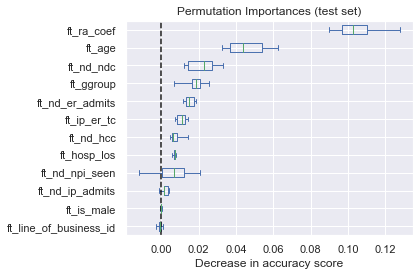

  3%|█▍                                          | 1/32 [00:03<02:02,  3.94s/it]

target:  tg_ip_er_tc_12m
raw_top30pct_spend_pct: 0.638191546456615
actual_top_30pct_spend_pct: 0.9852265566176763
pred_pct_of_actual: 0.6477612100180826


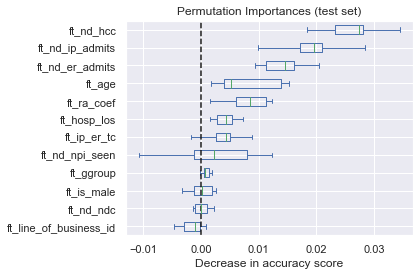

  6%|██▊                                         | 2/32 [00:05<01:14,  2.48s/it]

target:  tg_er_ddos_12m
raw_top30pct_spend_pct: 0.6577777777777778
actual_top_30pct_spend_pct: 0.9052991452991453
pred_pct_of_actual: 0.7265861027190332


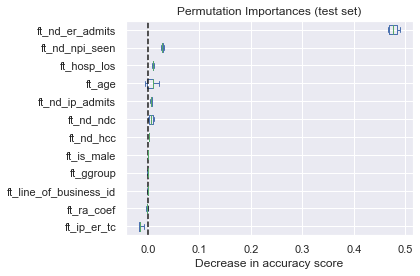

  9%|████▏                                       | 3/32 [00:07<01:07,  2.34s/it]

target:  tg_ip_ddos_12m
raw_top30pct_spend_pct: 0.6602739726027397
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6602739726027397


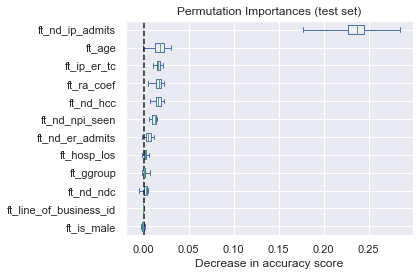

 12%|█████▌                                      | 4/32 [00:09<01:04,  2.31s/it]

target:  tg_tc_1m_2m
raw_top30pct_spend_pct: 0.5025460668193519
actual_top_30pct_spend_pct: 0.7804908841690106
pred_pct_of_actual: 0.6438846077676015


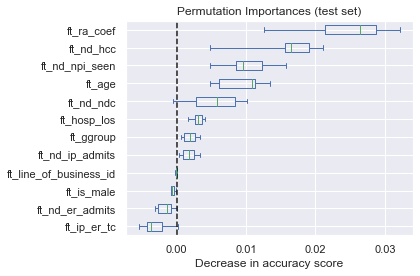

 16%|██████▉                                     | 5/32 [00:12<01:02,  2.30s/it]

target:  tg_ip_er_tc_1m_2m
raw_top30pct_spend_pct: 0.5763013272932265
actual_top_30pct_spend_pct: 1.0000000000000002
pred_pct_of_actual: 0.5763013272932264


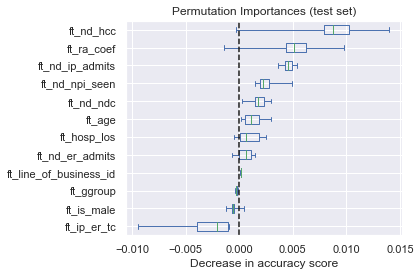

 19%|████████▎                                   | 6/32 [00:14<01:00,  2.34s/it]

target:  tg_er_ddos_1m_2m
raw_top30pct_spend_pct: 0.7316017316017316
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.7316017316017316


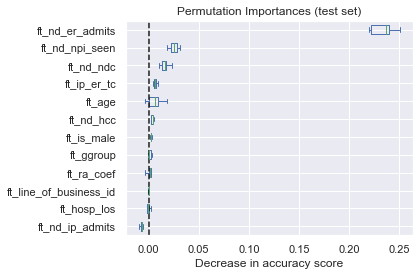

 22%|█████████▋                                  | 7/32 [00:16<00:57,  2.31s/it]

target:  tg_ip_ddos_1m_2m
raw_top30pct_spend_pct: 0.5636363636363636
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.5636363636363636


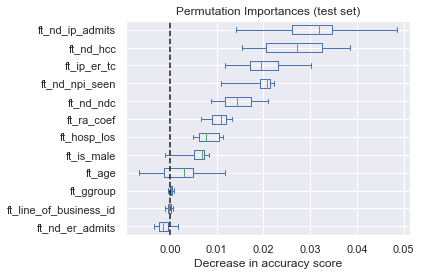

 25%|███████████                                 | 8/32 [00:18<00:54,  2.28s/it]

target:  tg_tc_1m_3m
raw_top30pct_spend_pct: 0.48915704795939413
actual_top_30pct_spend_pct: 0.7763567492412604
pred_pct_of_actual: 0.6300673607042783


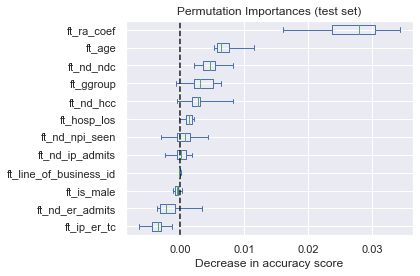

 28%|████████████▍                               | 9/32 [00:21<00:51,  2.24s/it]

target:  tg_ip_er_tc_1m_3m
raw_top30pct_spend_pct: 0.5050604192413636
actual_top_30pct_spend_pct: 1.0000000000000002
pred_pct_of_actual: 0.5050604192413635


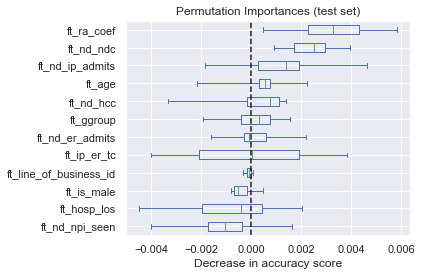

 31%|█████████████▍                             | 10/32 [00:23<00:48,  2.20s/it]

target:  tg_er_ddos_1m_3m
raw_top30pct_spend_pct: 0.6899383983572895
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6899383983572895


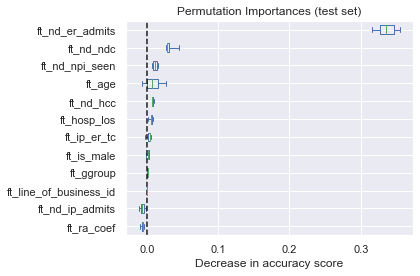

 34%|██████████████▊                            | 11/32 [00:25<00:47,  2.28s/it]

target:  tg_ip_ddos_1m_3m
raw_top30pct_spend_pct: 0.6428571428571429
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6428571428571429


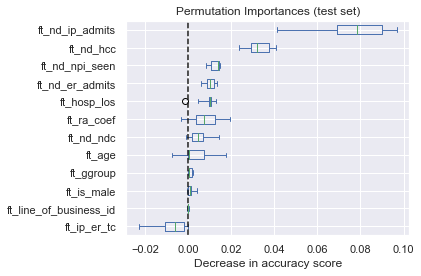

 38%|████████████████▏                          | 12/32 [00:27<00:44,  2.23s/it]

target:  tg_tc_1m_6m
raw_top30pct_spend_pct: 0.4856962661137056
actual_top_30pct_spend_pct: 0.7476744810953506
pred_pct_of_actual: 0.6496092596368351


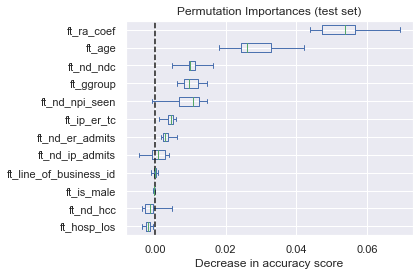

 41%|█████████████████▍                         | 13/32 [00:30<00:42,  2.23s/it]

target:  tg_ip_er_tc_1m_6m
raw_top30pct_spend_pct: 0.5390552526073608
actual_top_30pct_spend_pct: 0.9993754125983136
pred_pct_of_actual: 0.5393921501489124


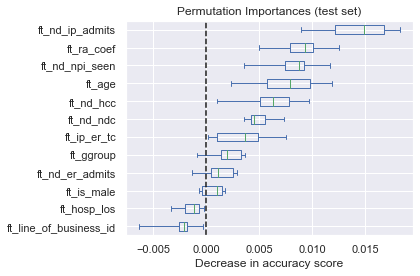

 44%|██████████████████▊                        | 14/32 [00:32<00:38,  2.15s/it]

target:  tg_er_ddos_1m_6m
raw_top30pct_spend_pct: 0.6772291820191599
actual_top_30pct_spend_pct: 0.9852616064848931
pred_pct_of_actual: 0.6873597606581899


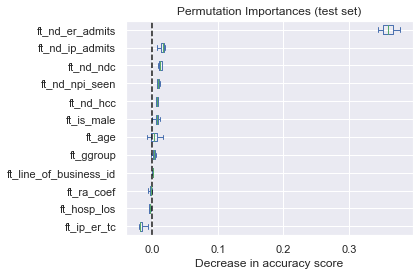

 47%|████████████████████▏                      | 15/32 [00:34<00:38,  2.24s/it]

target:  tg_ip_ddos_1m_6m
raw_top30pct_spend_pct: 0.6306306306306306
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6306306306306306


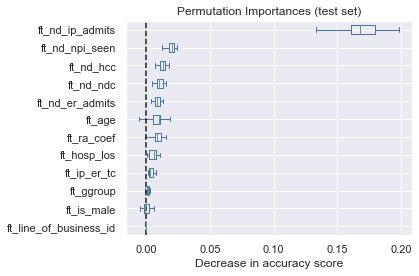

 50%|█████████████████████▌                     | 16/32 [00:36<00:35,  2.25s/it]

target:  tg_tc_2m
raw_top30pct_spend_pct: 0.507098487551254
actual_top_30pct_spend_pct: 0.7549224034177691
pred_pct_of_actual: 0.6717226634889374


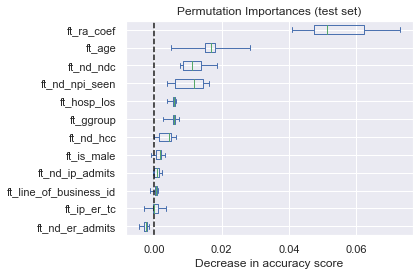

 53%|██████████████████████▊                    | 17/32 [00:39<00:33,  2.25s/it]

target:  tg_ip_er_tc_2m
raw_top30pct_spend_pct: 0.6160922858279502
actual_top_30pct_spend_pct: 0.9999999999999999
pred_pct_of_actual: 0.6160922858279503


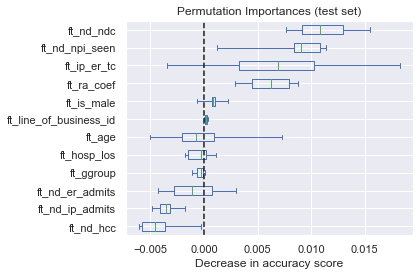

 56%|████████████████████████▏                  | 18/32 [00:41<00:31,  2.24s/it]

target:  tg_er_ddos_2m
raw_top30pct_spend_pct: 0.6864035087719298
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6864035087719298


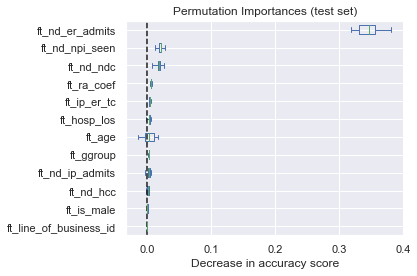

 59%|█████████████████████████▌                 | 19/32 [00:43<00:28,  2.19s/it]

target:  tg_ip_ddos_2m
raw_top30pct_spend_pct: 0.6792452830188679
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6792452830188679


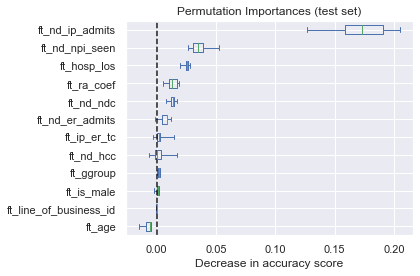

 62%|██████████████████████████▉                | 20/32 [00:45<00:27,  2.26s/it]

target:  tg_tc_3m
raw_top30pct_spend_pct: 0.49178398279492447
actual_top_30pct_spend_pct: 0.7543608369533006
pred_pct_of_actual: 0.6519214130748531


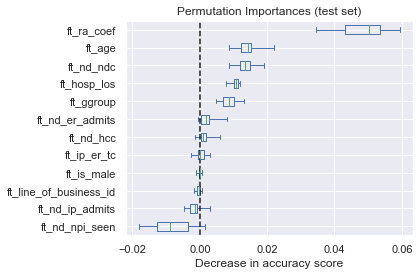

 66%|████████████████████████████▏              | 21/32 [00:47<00:24,  2.23s/it]

target:  tg_ip_er_tc_3m
raw_top30pct_spend_pct: 0.6736469136810507
actual_top_30pct_spend_pct: 0.9999999999999998
pred_pct_of_actual: 0.6736469136810508


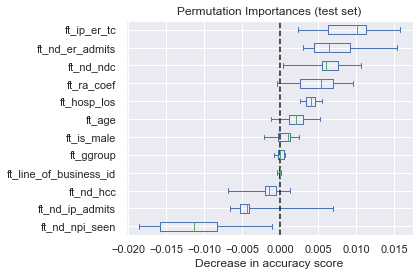

 69%|█████████████████████████████▌             | 22/32 [00:49<00:21,  2.18s/it]

target:  tg_er_ddos_3m
raw_top30pct_spend_pct: 0.6731843575418994
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6731843575418994


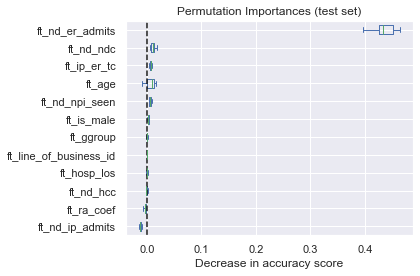

 72%|██████████████████████████████▉            | 23/32 [00:52<00:19,  2.20s/it]

target:  tg_ip_ddos_3m
raw_top30pct_spend_pct: 0.6748466257668712
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6748466257668712


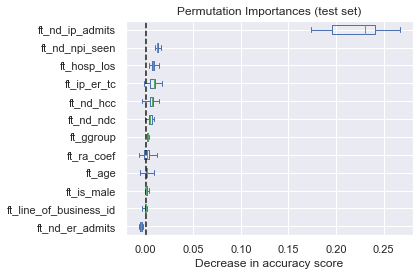

 75%|████████████████████████████████▎          | 24/32 [00:54<00:17,  2.14s/it]

target:  tg_tc_6m
raw_top30pct_spend_pct: 0.49761367409705787
actual_top_30pct_spend_pct: 0.7384613237241068
pred_pct_of_actual: 0.6738520462893858


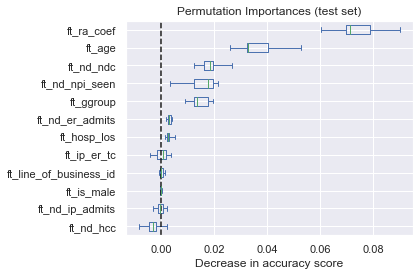

 78%|█████████████████████████████████▌         | 25/32 [00:56<00:15,  2.23s/it]

target:  tg_ip_er_tc_6m
raw_top30pct_spend_pct: 0.6204765148826281
actual_top_30pct_spend_pct: 0.9976460779480689
pred_pct_of_actual: 0.6219405143744035


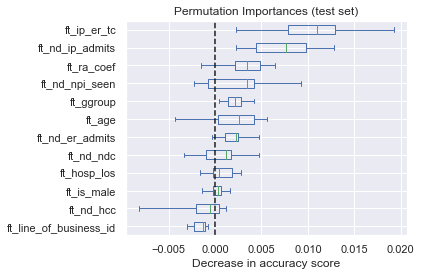

 81%|██████████████████████████████████▉        | 26/32 [00:58<00:13,  2.20s/it]

target:  tg_er_ddos_6m
raw_top30pct_spend_pct: 0.6723377441713926
actual_top_30pct_spend_pct: 0.9565217391304348
pred_pct_of_actual: 0.7028985507246377


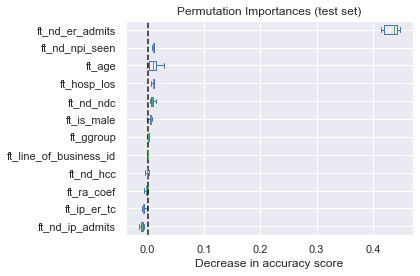

 84%|████████████████████████████████████▎      | 27/32 [01:01<00:11,  2.24s/it]

target:  tg_ip_ddos_6m
raw_top30pct_spend_pct: 0.6649214659685864
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6649214659685864


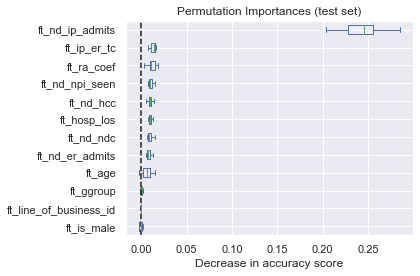

 88%|█████████████████████████████████████▋     | 28/32 [01:03<00:08,  2.24s/it]

target:  tg_tc_9m
raw_top30pct_spend_pct: 0.5055195290821107
actual_top_30pct_spend_pct: 0.7278487500170452
pred_pct_of_actual: 0.6945392556767765


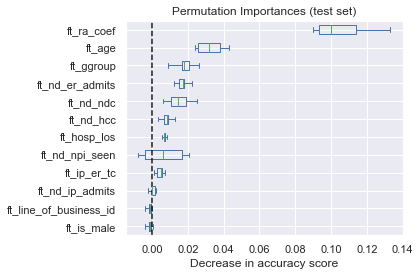

 91%|██████████████████████████████████████▉    | 29/32 [01:05<00:06,  2.30s/it]

target:  tg_ip_er_tc_9m
raw_top30pct_spend_pct: 0.6013590252009037
actual_top_30pct_spend_pct: 0.9916856951633886
pred_pct_of_actual: 0.6064008265258124


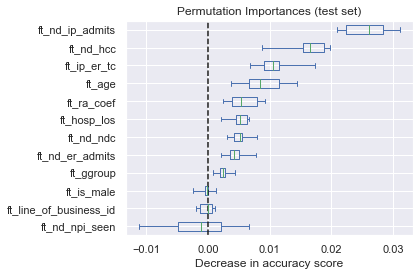

 94%|████████████████████████████████████████▎  | 30/32 [01:08<00:04,  2.32s/it]

target:  tg_er_ddos_9m
raw_top30pct_spend_pct: 0.662303664921466
actual_top_30pct_spend_pct: 0.9201570680628273
pred_pct_of_actual: 0.7197724039829303


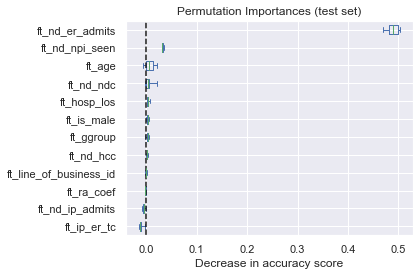

 97%|█████████████████████████████████████████▋ | 31/32 [01:10<00:02,  2.29s/it]

target:  tg_ip_ddos_9m
raw_top30pct_spend_pct: 0.6470588235294118
actual_top_30pct_spend_pct: 1.0
pred_pct_of_actual: 0.6470588235294118


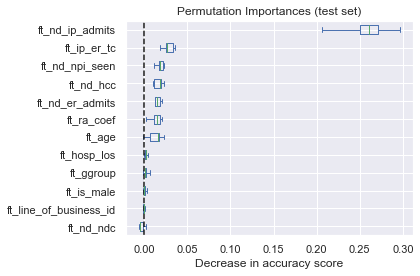

100%|███████████████████████████████████████████| 32/32 [01:12<00:00,  2.26s/it]


In [50]:
for target in tqdm(targets):
    print('target: ', target)
    base = HistGradientBoostingRegressor(categorical_features=cat_features,
                                         validation_fraction=0.1,
                                         max_depth=5,
                                         max_iter=1000)
    gbdt = BaggingRegressor(base,
                            n_estimators=10,
                            n_jobs=16)

    gbdt.fit(train_members[features], train_members[target])
    preds = gbdt.predict(df[features])

    df = df.assign(**{f'preds_{target}': preds})

    compute_results(target)
    plot_feature_imp(gbdt, target)


In [51]:
df.head()

,member_id,ft_age,ft_ggroup,ft_line_of_business_id,ft_is_male,ft_nd_ip_admits,ft_hosp_los,ft_nd_er_admits,ft_nd_npi_seen,ft_nd_ndc,ft_nd_hcc,ft_hcc_list,ft_ra_coef,ft_ip_er_tc,tg_tc_12m,tg_ip_er_tc_12m,tg_er_ddos_12m,tg_ip_ddos_12m,tg_tc_1m_2m,tg_ip_er_tc_1m_2m,tg_er_ddos_1m_2m,tg_ip_ddos_1m_2m,tg_tc_1m_3m,tg_ip_er_tc_1m_3m,tg_er_ddos_1m_3m,tg_ip_ddos_1m_3m,tg_tc_1m_6m,tg_ip_er_tc_1m_6m,tg_er_ddos_1m_6m,tg_ip_ddos_1m_6m,tg_tc_2m,tg_ip_er_tc_2m,tg_er_ddos_2m,tg_ip_ddos_2m,tg_tc_3m,tg_ip_er_tc_3m,tg_er_ddos_3m,tg_ip_ddos_3m,tg_tc_6m,tg_ip_er_tc_6m,tg_er_ddos_6m,tg_ip_ddos_6m,tg_tc_9m,tg_ip_er_tc_9m,tg_er_ddos_9m,tg_ip_ddos_9m,is_test_set,preds_tg_tc_12m,preds_tg_ip_er_tc_12m,preds_tg_er_ddos_12m,preds_tg_ip_ddos_12m,preds_tg_tc_1m_2m,preds_tg_ip_er_tc_1m_2m,preds_tg_er_ddos_1m_2m,preds_tg_ip_ddos_1m_2m,preds_tg_tc_1m_3m,preds_tg_ip_er_tc_1m_3m,preds_tg_er_ddos_1m_3m,preds_tg_ip_ddos_1m_3m,preds_tg_tc_1m_6m,preds_tg_ip_er_tc_1m_6m,preds_tg_er_ddos_1m_6m,preds_tg_ip_ddos_1m_6m,preds_tg_tc_2m,preds_tg_ip_er_tc_2m,preds_tg_er_ddos_2m,preds_tg_ip_ddos_2m,preds_tg_tc_3m,preds_tg_ip_er_tc_3m,preds_tg_er_ddos_3m,preds_tg_ip_ddos_3m,preds_tg_tc_6m,preds_tg_ip_er_tc_6m,preds_tg_er_ddos_6m,preds_tg_ip_ddos_6m,preds_tg_tc_9m,preds_tg_ip_er_tc_9m,preds_tg_er_ddos_9m,preds_tg_ip_ddos_9m
0,252421,21,3.0,1,1,0,0,1,13,4,1,{74},0.339,1722.75,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0,True,33900.818281,7180.582467,1.291234,0.225539,1817.944831,569.596190,0.097972,0.023368,4390.026333,1387.648520,0.253020,0.048076,15381.250430,2395.191406,0.640867,0.122830,3812.331765,808.010946,0.185104,0.037158,6286.509361,1773.178922,0.337126,0.057893,16660.032289,2507.095765,0.717038,0.115086,21848.661346,4375.844210,1.074431,0.200372
1,252423,55,3.0,1,0,0,0,2,13,107,4,"{40,59,108,111}",1.353,1853.52,35110.52,0.00,0,0,3829.83,0.0,0,0,7577.85,0.0,0,0,15416.64,0.00,0,0,8922.05,0.0,0,0,14089.47,0.0,0,0,21819.44,0.00,0,0,28232.84,0.00,0,0,False,47531.165262,12904.999393,2.321563,0.408942,3464.475259,617.307815,0.145920,0.030507,7013.604177,1891.457002,0.393613,0.074774,17204.594109,4359.081120,1.185685,0.143609,7782.906087,1850.385910,0.309459,0.059503,12503.448914,2744.805358,0.543913,0.098412,23064.574769,5240.314816,1.261834,0.180313,35650.089289,9058.399818,1.953151,0.297065
2,252425,52,3.0,1,0,0,0,0,1,18,0,NaN,0.000,0.00,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.0,0,0,0.00,0.0,0,0,0.00,0.00,0,0,0.00,0.00,0,0,False,24821.021019,7370.859663,1.051646,0.292195,1901.006333,630.418549,0.068575,0.025047,4298.329052,1369.038388,0.143330,0.058548,11032.489476,3385.309059,0.450147,0.122113,4255.470670,1172.658118,0.116598,0.045456,6119.315833,2299.440791,0.210830,0.067088,13374.638369,3799.337418,0.498204,0.151787,21410.967905,6480.142369,0.799765,0.209839
3,252427,29,3.0,1,0,1,57,0,3,58,5,"{18,19,85,96,135}",1.441,0.00,42151.38,0.00,0,0,3193.08,0.0,0,0,6912.71,0.0,0,0,18984.24,0.00,0,0,6726.99,0.0,0,0,10446.62,0.0,0,0,22518.15,0.00,0,0,33604.63,0.00,0,0,False,45469.596511,7803.021060,1.165099,0.443043,4921.108565,842.051261,0.091736,0.037827,9257.680884,1405.641394,0.176099,0.071190,27373.011026,3743.048556,0.644511,0.162692,8117.505876,1378.500109,0.178618,0.061218,12871.962588,2154.167043,0.269430,0.085690,25873.310108,4480.053591,0.725263,0.253780,39108.324609,7645.048584,0.914158,0.393628
4,252430,48,3.0,1,0,0,0,0,5,48,7,"{19,40,55,56,59,79,111}",2.048,0.00,82698.32,745.62,1,0,2470.00,0.0,0,0,8840.16,0.0,0,0,23973.11,745.62,1,0,5899.20,0.0,0,0,12256.29,0.0,0,0,27402.28,745.62,1,0,55651.71,745.62,1,0,False,56092.196544,14470.995569,1.421569,0.427871,3551.405093,708.221115,0.104813,0.027971,7578.421066,1538.484347,0.212590,0.061396,19158.193410,4985.841306,0.681777,0.159695,7916.658474,2022.068460,0.201280,0.050324,11432.974752,2313.167856,0.313691,0.082291,22690.101427,5383.044098,0.682278,0.180093,38378.584087,9779.683260,1.071440,0.314148


In [53]:
# df.to_sql('uhc_tx_risk_model_ml_20221001',
#           cb_utils.get_engine(),
#           schema='junk',
#           index=False,
#           chunksize=500,
#           method='multi')

13837